# Main_file_Model Defining Processing

In [1]:
!pip install lightgbm


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\jh102\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance 
from collections import defaultdict

In [ ]:
from Model_Def import calculate_metrics, get_feature_importances # feature importance
from Model_Def import mean_variance_portfolio, minimum_variance_portfolio, minimum_variance_portfolio, risk_parity_portfolio, equal_weighting_portfolio # Portfolio Optimization
from Model_Def import create_scenarios,mahalanobis_distance, calculate_probabilities # Create Senarios
from calculate_modularity import visualize_edge_graph, visualize_edge_graph_3d, calculate_louvain

# Data
df_factor = pd.read_csv("df_factor.csv").set_index('Unnamed: 0') #월별 경제지표 정보 (2004~2023)
df_KOSPI = pd.read_csv("df_KOSPI.csv").set_index('date') # 코스피지수 증감률 정보 (2004~2023)
df_sector = pd.read_csv("df_sector.csv").set_index('date') # 코스피 주식 섹터별 수익률(월별) 정보 (2010-08~2023-12) 
df_stock = pd.read_csv("df_stock.csv").set_index('date') # 코스피200 개별종목정보 (월별) (2010-08 ~ 2023-12)

In [8]:
# 데이터의 총 개수 계산
n = len(df_factor)

# 훈련 데이터의 크기 계산 (80%)
train_size = int(n * 0.8)

# 훈련 세트와 테스트 세트로 분할
X_train = df_factor[:train_size]
X_test = df_factor[train_size:]
y_train = df_KOSPI[:train_size]
y_test = df_KOSPI[train_size:]  

# y_train과 y_test를 1차원 배열로 변환 (필요에 따라)
y_train = y_train.squeeze()
y_test = y_test.squeeze()

# 훈련 세트와 테스트 세트의 크기 출력
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (192, 34)
X_test shape: (48, 34)
y_train shape: (192,)
y_test shape: (48,)


In [9]:
# 인공신경망 모델의 하이퍼파라미터 설정
nn_params = {
    'hidden_layer_sizes': (34,) * 5,  # 5개의 히든 레이어, 각 레이어에 34개의 노드
    'activation': 'relu',  # 활성화 함수로 ReLU 사용
    'max_iter': 100,  # 최대 100번의 반복 학습
    'early_stopping': True,  # 조기 종료 사용
    'random_state': 42  # 난수 시드 고정
}

# 서포트 벡터 머신 모델의 하이퍼파라미터 설정
svm_params = {
    'kernel': 'rbf',  # RBF 커널 사용
    'gamma': 'scale'  # gamma 값은 'scale'로 설정
}

# 랜덤 포레스트 모델 (LightGBM)의 하이퍼파라미터 설정
rf_params = {
    'num_leaves': 31,  # 최대 리프 노드 수
    'max_depth': 8,  # 트리의 최대 깊이
    'learning_rate': 0.1,  # 학습률
    'n_estimators': 150,  # 결정 트리의 개수
    'min_child_samples': 12,  # 내부 노드의 최소 샘플 수
    'min_data_in_leaf': 12,  # 리프 노드의 최소 샘플 수
    'random_state': 42,  # 난수 시드 고정
    'verbose': -1  # 로그 메시지 비활성화
}

models = {
    'Linear Regression': LinearRegression(),  # 선형 회귀 모델
    'Random Forest': LGBMRegressor(**rf_params),  # 랜덤 포레스트 모델 (LightGBM 사용)
    'Support Vector Machine': SVR(**svm_params),  # 서포트 벡터 머신 모델
    'Neural Network': MLPRegressor(**nn_params)  # 인공신경망 모델
}

# Model Evaluation and Ranking

In [10]:
# 모델 학습 및 평가
results = {}
for model_name, model in models.items():
    # 모델 학습
    model.fit(X_train, y_train)  # .values.ravel() 사용하여 2D 배열을 1D로 변환
    
    # 테스트 데이터에 대한 예측
    y_pred = model.predict(X_test)
    
    # 예측 결과와 실제 값으로 메트릭 계산 및 저장
    results[model_name] = calculate_metrics(y_test, y_pred)  # .values 사용하여 2D 배열을 1D로 변환

# 평가 결과를 데이터프레임으로 변환하여 출력
results_df = pd.DataFrame(results).T
results_df

C:\Users\jh102\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\jh102\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\jh102\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)`

,RMSE,MAE,MAPE,Correlation,Sign Accuracy,Directional Accuracy
Linear Regression,0.064278,0.051018,1.598016,0.338800,0.583333,0.744681
Random Forest,0.051405,0.040383,1.211354,0.550750,0.687500,0.659574
Support Vector Machine,0.061504,0.049916,1.358902,0.238545,0.625000,0.659574
Neural Network,0.135284,0.107051,4.560933,-0.025119,0.541667,0.595745


In [11]:
# 각 지표에 대해 모델의 순위를 매기기
results_df['RMSE_rank'] = results_df['RMSE'].rank()
results_df['MAE_rank'] = results_df['MAE'].rank()
results_df['MAPE_rank'] = results_df['MAPE'].rank()
# results_df['Correlation_rank'] = results_df['Correlation'].rank(ascending=False)  # 상관관계는 클수록 좋음
# results_df['Sign Accuracy_rank'] = results_df['Sign Accuracy'].rank(ascending=False)  # 클수록 좋음
# results_df['Directional Accuracy_rank'] = results_df['Directional Accuracy'].rank(ascending=False)  # 클수록 좋음

# 각 지표의 순위를 합산하여 종합 순위 계산
results_df['Total_rank'] = results_df[['RMSE_rank', 'MAE_rank', 'MAPE_rank']].sum(axis=1)
# , 'Correlation_rank', 'Sign Accuracy_rank', 'Directional Accuracy_rank'
# 종합 순위가 가장 낮은 모델 선택
best_model_name = results_df['Total_rank'].idxmin()
best_model_metrics = results_df.loc[best_model_name]

# 최적의 모델 출력
print(f"The best model is: {best_model_name}")

# 결과 데이터프레임 출력
results_df

The best model is: Random Forest


,RMSE,MAE,MAPE,Correlation,Sign Accuracy,Directional Accuracy,RMSE_rank,MAE_rank,MAPE_rank,Total_rank
Linear Regression,0.064278,0.051018,1.598016,0.338800,0.583333,0.744681,3.0,3.0,3.0,9.0
Random Forest,0.051405,0.040383,1.211354,0.550750,0.687500,0.659574,1.0,1.0,1.0,3.0
Support Vector Machine,0.061504,0.049916,1.358902,0.238545,0.625000,0.659574,2.0,2.0,2.0,6.0
Neural Network,0.135284,0.107051,4.560933,-0.025119,0.541667,0.595745,4.0,4.0,4.0,12.0


# Feature Importance

In [12]:
# 각 모델에 대해 특성 중요도 계산
feature_importances = {}
for model_name, model in models.items():
    importances = get_feature_importances(model, X_train, y_train)
    feature_importances[model_name] = importances

# 데이터프레임으로 변환
feature_importances_df = pd.DataFrame(feature_importances, index=X_train.columns)

# 각 모델에 대해 평균 중요도를 초과하는 중요한 특성 식별
important_features = defaultdict(list)
model_selected_features = {}

for model_name in models.keys():
    mean_importance = feature_importances_df[model_name].mean()
    selected_features = feature_importances_df[feature_importances_df[model_name] > mean_importance].index.tolist()
    model_selected_features[model_name] = selected_features
    for feature in selected_features:
        important_features[feature].append(model_name)

# 각 모델의 중요한 특성 리스트를 동일한 길이로 맞추기
max_len = max(len(features) for features in model_selected_features.values())

for model_name in model_selected_features.keys():
    selected_features = model_selected_features[model_name]
    if len(selected_features) < max_len:
        selected_features.extend([np.nan] * (max_len - len(selected_features)))
    model_selected_features[model_name] = selected_features

# 중요한 특성 데이터프레임 생성
important_features_df = pd.DataFrame(model_selected_features)

# 중요한 특성 데이터프레임 출력
important_features_df

C:\Users\jh102\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\jh102\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\jh102\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)`

,Linear Regression,Random Forest,Support Vector Machine,Neural Network
0,BR,INF,UR,BR
1,CP,T1,USDKRW,T10
2,AAA,AAA,PPI,AAA
3,USDKRW,UR,M1Y,BBB
4,DE1,USDKRW,M2Y,UR
5,DE3,M1M,NaN,USDKRW
6,DE6,TE5,NaN,PPI
7,NaN,NaN,NaN,M1Y
8,NaN,NaN,NaN,M2Y
9,NaN,NaN,NaN,DE4


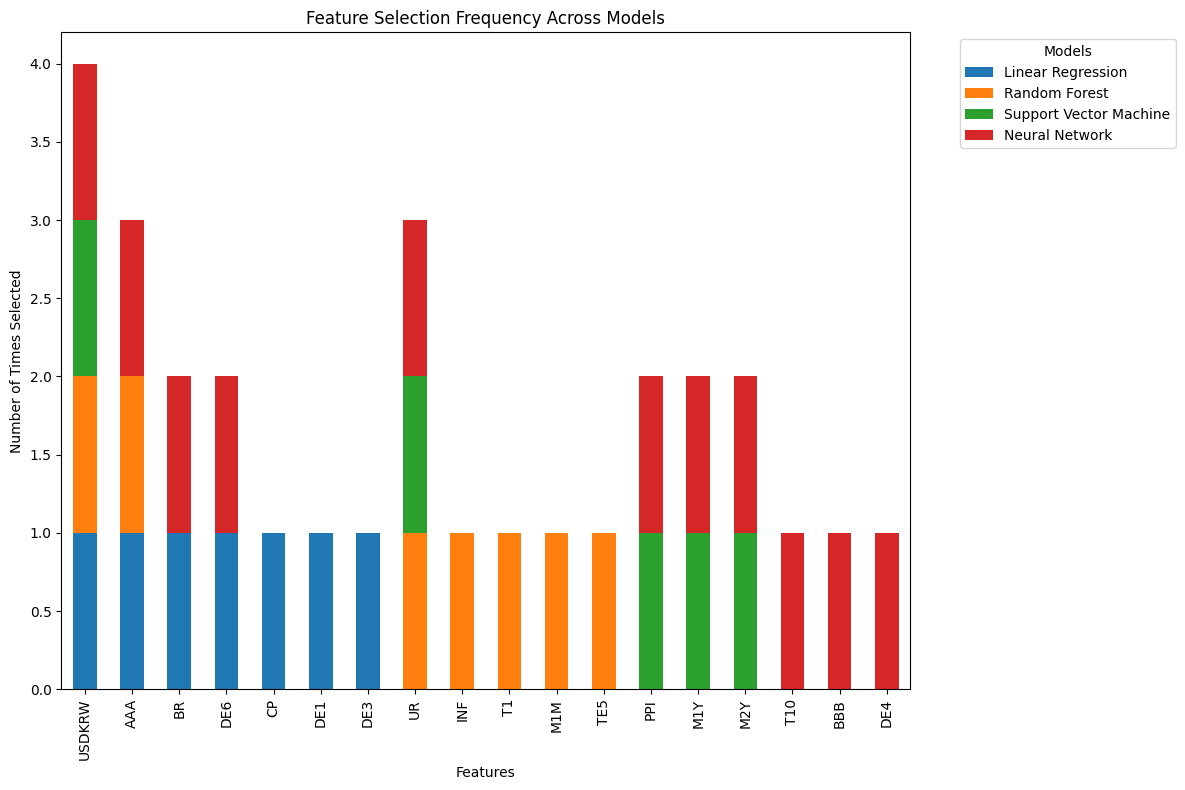

In [13]:
# 각 모델별로 선택된 특성의 횟수 계산
feature_counter = defaultdict(lambda: defaultdict(int))
for feature, model_list in important_features.items():
    for model in model_list:
        feature_counter[feature][model] += 1

# 데이터프레임으로 변환
feature_counts_df = pd.DataFrame(feature_counter).fillna(0).T

# 모델 이름 순서에 맞게 열 정렬
model_names = list(models.keys())
feature_counts_df = feature_counts_df[model_names]
feature_counts_df.sort_values(by=model_names, ascending=False, inplace=True)

# 시각화
feature_counts_df.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.xlabel('Features')
plt.ylabel('Number of Times Selected')
plt.title('Feature Selection Frequency Across Models')
plt.xticks(rotation=90)
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

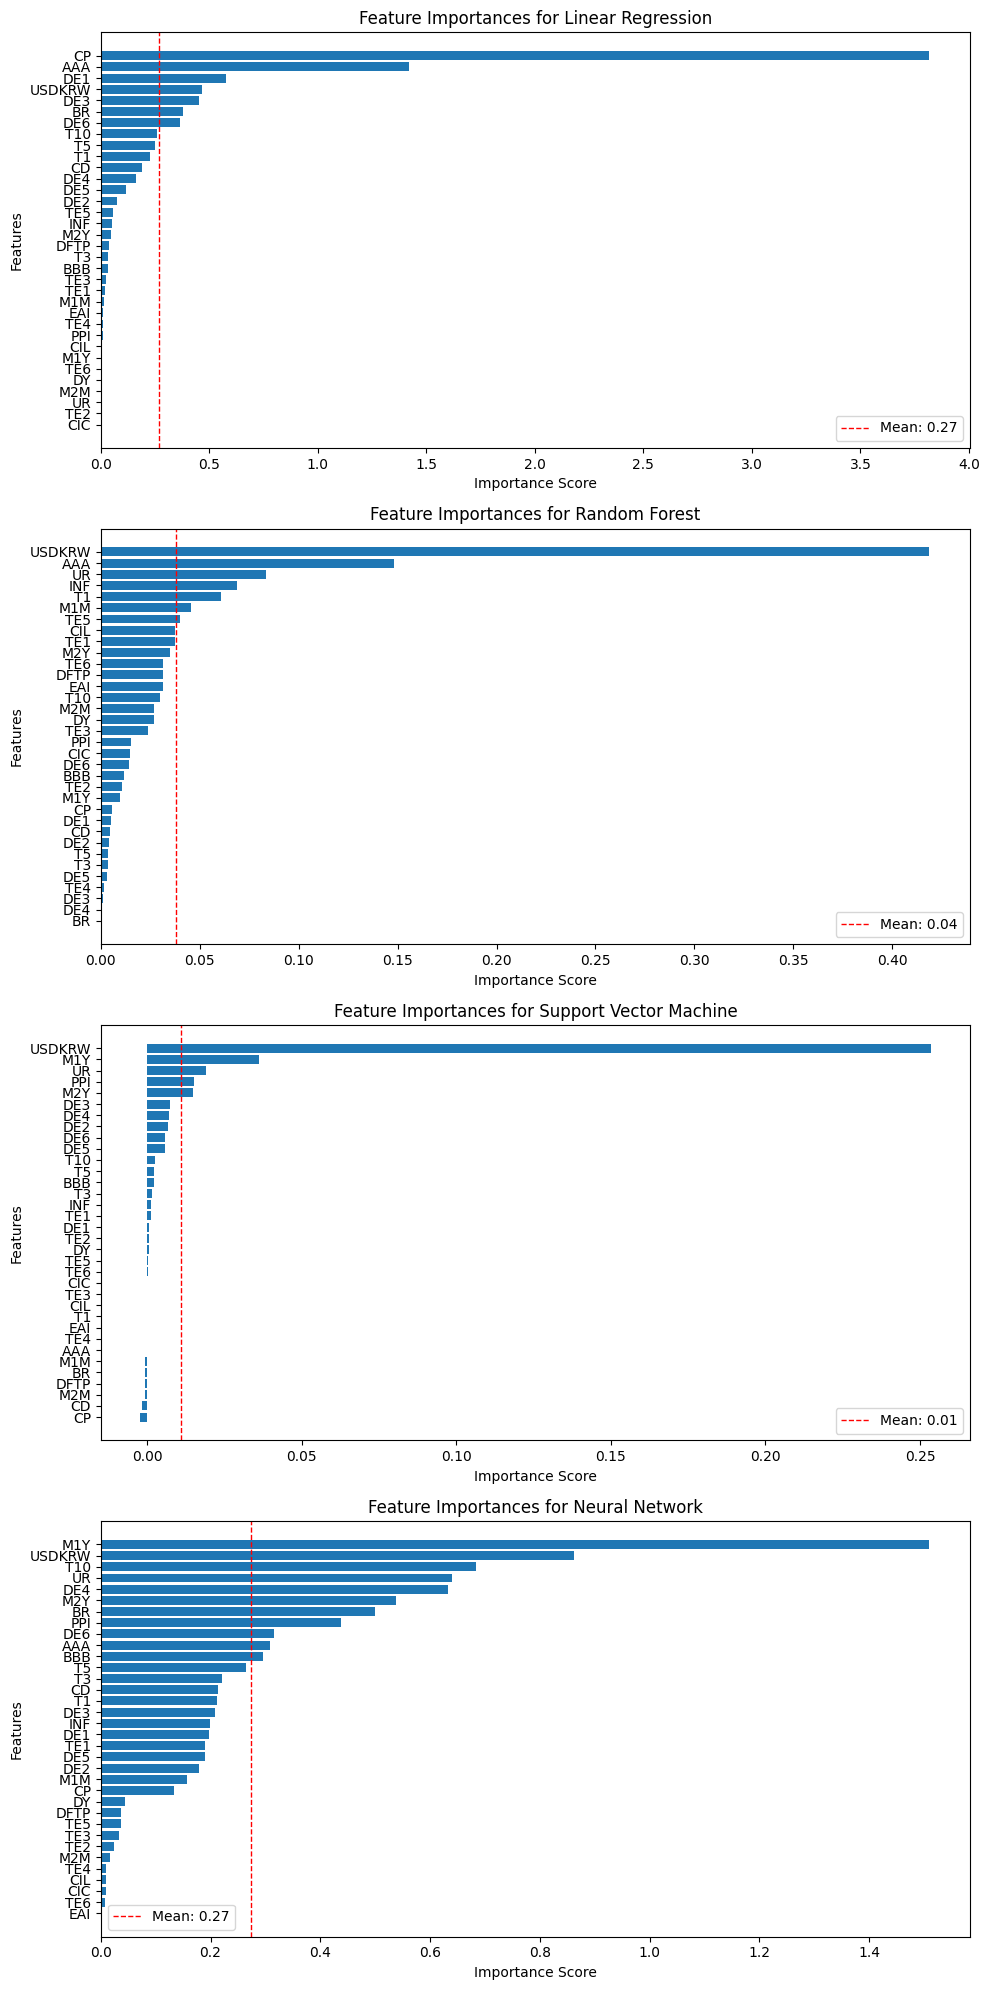

In [14]:
# 각 모델별 순열 특성 중요도 시각화
fig, axes = plt.subplots(len(models), 1, figsize=(10, len(models) * 5))
for ax, (model_name, importances) in zip(axes, feature_importances.items()):
    sorted_idx = np.argsort(importances)
    mean_importance = np.mean(importances)
    
    ax.barh(range(len(importances)), importances[sorted_idx], align='center')
    ax.axvline(x=mean_importance, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_importance:.2f}')
    ax.set_yticks(range(len(importances)))
    ax.set_yticklabels(np.array(X_train.columns)[sorted_idx])
    ax.set_title(f'Feature Importances for {model_name}')
    ax.set_xlabel('Importance Score')
    ax.set_ylabel('Features')
    ax.legend()

plt.tight_layout()
plt.show()

# 중요한 특성을 활용한 모델 재학습

In [15]:
# 각 모델의 중요한 특성들을 이용하여 모델을 재학습 및 평가
results_important = {}

for model_name, model in models.items():
    # 해당 모델의 중요한 특성 선택
    selected_features = important_features_df[model_name].dropna().tolist()
    
    # 중요한 특성만 포함하는 훈련 및 테스트 데이터 생성
    X_train_important = X_train[selected_features]
    X_test_important = X_test[selected_features]
    
    # 모델 학습
    model.fit(X_train_important, y_train)
    
    # 예측 및 평가
    y_pred = model.predict(X_test_important)
    results_important[model_name] = calculate_metrics(y_test, y_pred)

# 결과를 데이터프레임으로 변환하여 출력
results_important_df = pd.DataFrame(results_important).T
results_important_df

C:\Users\jh102\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\jh102\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\jh102\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)`

,RMSE,MAE,MAPE,Correlation,Sign Accuracy,Directional Accuracy
Linear Regression,0.064247,0.051912,1.502009,0.195331,0.604167,0.723404
Random Forest,0.057766,0.048035,1.568436,0.399404,0.729167,0.723404
Support Vector Machine,0.062391,0.050250,1.231959,0.152170,0.604167,0.531915
Neural Network,0.180045,0.145450,4.637662,-0.354982,0.375000,0.531915


In [16]:
# 각 지표에 대해 모델의 순위를 매기기
results_important_df['RMSE_rank'] = results_important_df['RMSE'].rank()
results_important_df['MAE_rank'] = results_important_df['MAE'].rank()
results_important_df['MAPE_rank'] = results_important_df['MAPE'].rank()
# results_important_df['Correlation_rank'] = results_important_df['Correlation'].rank(ascending=False)  # 상관관계는 클수록 좋음
# results_important_df['Sign Accuracy_rank'] = results_important_df['Sign Accuracy'].rank(ascending=False)  # 클수록 좋음
# results_important_df['Directional Accuracy_rank'] = results_important_df['Directional Accuracy'].rank(ascending=False)  # 클수록 좋음

# 각 지표의 순위를 합산하여 종합 순위 계산
results_important_df['Total_rank'] = results_important_df[['RMSE_rank', 'MAE_rank', 'MAPE_rank']].sum(axis=1)
# , 'Correlation_rank', 'Sign Accuracy_rank', 'Directional Accuracy_rank'

# 종합 순위가 가장 낮은 모델 선택
best_model_name = results_important_df['Total_rank'].idxmin()
best_model_metrics = results_important_df.loc[best_model_name]

# 최적의 모델 출력
print(f"The best model is: {best_model_name}")

The best model is: Random Forest


# 모델 재학습

In [17]:
# RF 모델의 중요한 특성을 사용하여 데이터 준비
RF_important_features = important_features_df[best_model_name].dropna().tolist()
X_RF = df_factor[RF_important_features].loc['2010-08':'2023-12']

results_stock = {}
important_features_stock = {}

for target in df_stock.columns:
    # 데이터의 총 개수 계산
    n = len(X_RF)
    
    # 훈련 데이터의 크기 계산 (80%)
    train_size = int(n * 0.8)
    
    # 훈련 세트와 테스트 세트로 분할
    X_train_RF = X_RF[:train_size]
    X_test_RF = X_RF[train_size:]
    y_train = df_stock[target][:train_size]
    y_test = df_stock[target][train_size:]

    # RF 모델 학습 및 평가
    RF_model = models[best_model_name]
    RF_model.fit(X_train_RF, y_train)
    y_pred = RF_model.predict(X_test_RF)
    results_RF = calculate_metrics(y_test, y_pred)
    
    # 결과 저장
    results_stock[target] = results_RF
    
    # 순열 중요도 계산
    result = permutation_importance(RF_model, X_test_RF, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    important_features_stock[target] = result.importances_mean

# 결과를 데이터프레임으로 변환하여 출력
results_all_df = pd.DataFrame(results_stock).T
results_all_df

C:\Users\jh102\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\jh102\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\jh102\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instea

,RMSE,MAE,MAPE,Correlation,Sign Accuracy,Directional Accuracy
A005930,0.065204,0.053545,inf,0.295057,0.515152,0.59375
A000660,0.098013,0.079633,inf,0.273952,0.454545,0.56250
A005380,0.084057,0.068086,inf,0.028500,0.515152,0.53125
A068270,0.147041,0.122295,5.628016,0.187503,0.575758,0.59375
A000270,0.096893,0.078961,2.035109,-0.057330,0.515152,0.53125
...,...,...,...,...,...,...
A001680,0.114402,0.100265,3.842118,-0.022284,0.515152,0.43750
A016380,0.285582,0.162018,2.150033,-0.179142,0.515152,0.56250
A000670,0.135828,0.103497,3.303700,-0.030269,0.424242,0.56250
A105630,0.140844,0.113422,inf,0.128422,0.484848,0.56250


In [18]:
# 중요도를 데이터프레임으로 변환하여 출력
importance_df = pd.DataFrame(important_features_stock, index=RF_important_features)
importance_df

,A005930,A000660,A005380,A068270,A000270,A105560,A005490,A055550,A035420,A051910,...,A001430,A114090,A005250,A093370,A003030,A001680,A016380,A000670,A105630,A008730
INF,0.042941,0.031047,-0.026088,0.026872,0.042278,0.000995,-0.002101,0.020337,0.103709,0.002805,...,-0.057858,-0.009886,0.000824,-0.125570,-0.030444,-0.105918,0.011378,0.031390,0.003001,-0.003199
T1,0.012221,-0.181465,0.038612,0.079092,0.116585,-0.060367,-0.030402,-0.089416,0.139089,-0.049294,...,0.117528,0.015015,0.023824,-0.114025,-0.003886,-0.678154,-0.050877,-0.157509,0.012927,0.049629
AAA,-0.108651,-0.029044,0.074110,-0.005523,0.105216,0.019231,0.033177,-0.002437,-0.024899,-0.022397,...,-0.066853,0.028531,0.066833,0.073559,0.034020,-0.290930,-0.014911,-0.124985,0.052973,-0.021423
UR,-0.057687,0.044263,0.057708,-0.043883,-0.003330,-0.001331,-0.046281,0.004841,0.014243,0.101287,...,-0.024210,-0.020973,-0.201537,-0.048808,0.050223,-0.502487,0.004211,-0.051739,-0.014022,0.021641
USDKRW,0.219659,0.695311,0.136737,-0.016127,-0.108595,0.430615,0.371627,0.330676,-0.052623,0.409753,...,0.066644,0.013739,0.517272,0.165849,0.008843,0.132287,-0.050388,-0.015068,-0.048505,0.157636
M1M,0.005251,-0.114689,0.168293,0.055253,0.236706,-0.002076,0.001508,0.040184,0.047403,-0.026240,...,0.027272,-0.014274,0.085791,0.169631,0.096500,-0.310055,0.024927,-0.306661,0.523293,-0.006971
TE5,0.100184,0.201239,-0.037645,0.164443,0.054948,0.031292,-0.002550,0.116432,0.063096,0.031021,...,0.001637,-0.073620,0.079950,0.102074,0.287230,-0.218901,-0.044230,-0.038002,0.122677,0.092192


In [19]:
# 중요도 순위 매기기
importance_rank_df = importance_df.rank(ascending=False)
importance_rank_df['Average Rank'] = importance_rank_df.mean(axis=1)

# 평균 순위로 정렬하여 높은 순으로 나열
importance_rank_df.sort_values('Average Rank', inplace=True)

# 정렬된 중요 특성 리스트
sorted_features = importance_rank_df.index.tolist()

# 높은 순으로 정렬된 중요도 순위 출력
print("Sorted important features across all columns (high to low):")
sorted_features

Sorted important features across all columns (high to low):


['USDKRW', 'TE5', 'INF', 'T1', 'M1M', 'UR', 'AAA']

# Portfolio Optimization

In [ ]:
from scipy.optimize import minimize

df_stock_portfolio = df_stock.loc['2019-01':'2023-12']

# 기대 수익률과 공분산 행렬 계산
mean_returns = df_stock_portfolio.mean()
cov_matrix = df_stock_portfolio.cov()

df_stock_portfolio.head() #2019~2023

,A005930,A000660,A005380,A068270,A000270,A105560,A005490,A055550,A035420,A051910,...,A001430,A114090,A005250,A093370,A003030,A001680,A016380,A000670,A105630,A008730
date,,,,,,,,,,,,,,,,,,,,,
2019-01,0.192506,0.221488,0.092827,-0.015732,0.078635,0.033333,0.127572,0.090909,0.114754,0.060519,...,0.002825,0.034137,-0.047809,0.113150,0.064909,0.005988,0.453271,0.030872,0.030227,0.158915
2019-02,-0.022752,-0.052774,-0.023166,-0.066213,0.005502,-0.077003,-0.040146,0.010417,-0.022059,0.061141,...,0.087324,-0.083495,0.094142,-0.013264,0.003810,0.097222,0.087878,0.028646,0.180929,-0.100334
2019-03,-0.009978,0.060000,-0.055336,-0.114912,-0.032832,-0.056370,-0.038023,-0.037801,-0.067669,-0.062740,...,-0.007772,-0.040254,-0.078394,-0.084673,-0.009488,0.025316,-0.203943,0.012658,0.180124,-0.037175
2019-04,0.026876,0.064690,0.158996,0.171269,0.280057,0.103943,0.007905,0.050000,-0.036290,-0.013661,...,0.026110,0.026490,0.010373,0.075075,0.072797,-0.063492,0.250028,-0.031250,0.015789,0.100386
2019-05,-0.073064,-0.173418,-0.028881,-0.103772,-0.130387,-0.051948,-0.068627,0.007937,-0.066946,-0.077562,...,-0.127226,-0.135484,-0.121150,-0.103536,-0.044643,-0.058380,-0.171295,-0.091613,-0.227979,-0.080702


In [22]:
# 포트폴리오 구성
target_returns = [0.05, 0.07, 0.10]

portfolio_weights = pd.DataFrame(index = df_stock_portfolio.columns)

for target in target_returns:
    weights = mean_variance_portfolio(mean_returns, cov_matrix, target)
    column_name = f'Mean-Variance {target*100:.2f}%'
    portfolio_weights[column_name] = weights

# 최소 분산 모형
min_variance_weights = minimum_variance_portfolio(cov_matrix)
portfolio_weights['Minimum Variance'] = min_variance_weights

# 위험 동등 모형
risk_parity_weights = risk_parity_portfolio(cov_matrix)
portfolio_weights['Risk Parity'] = risk_parity_weights

# 동일 비중 모형
equal_weight_weights = equal_weighting_portfolio(len(mean_returns))
portfolio_weights['Equal Weighting'] = equal_weight_weights

# 데이터프레임 전체를 소수점 두 자리로 반올림
portfolio_weights = portfolio_weights.round(2)
portfolio_weights.T

,A005930,A000660,A005380,A068270,A000270,A105560,A005490,A055550,A035420,A051910,...,A001430,A114090,A005250,A093370,A003030,A001680,A016380,A000670,A105630,A008730
Mean-Variance 5.00%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,7.50,0.00,0.00,0.00,0.00,0.00
Mean-Variance 7.00%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Mean-Variance 10.00%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Minimum Variance,0.00,0.00,0.00,3.98,0.00,0.00,0.00,0.00,1.37,0.00,...,0.00,0.00,0.00,3.21,0.00,0.00,0.00,0.00,0.00,0.00
Risk Parity,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,...,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71
Equal Weighting,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,...,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71


# Senario Analysis

## 사례 1 (최근 2년)
## 사례 2 (코로나19 이후 금리 및 물가 상승 기간(2020년 1월 ~ 2022년 3월, 2년 3개월))

In [23]:
df_factor_scenario_1 = df_factor[sorted_features].loc['2022-01':'2023-12']
df_factor_scenario_1.head()

,USDKRW,TE5,INF,T1,M1M,UR,AAA
Unnamed: 0,,,,,,,
2022-01,1.425559,0.14,3.770784,1.422,1.168784,9.677419,2.632
2022-02,0.024950,0.25,3.780272,1.480,-0.044034,0.000000,2.873
2022-03,0.673485,0.25,4.183032,1.586,0.687404,-17.647059,3.028
2022-04,4.839775,0.14,4.755834,2.002,-0.029249,0.000000,3.631
2022-05,-1.859146,0.02,5.340519,2.049,0.560153,0.000000,3.775


In [24]:
df_scenarios_1 = create_scenarios(df_factor_scenario_1)
df_scenarios_1

,Normal,Weak,Robust
USDKRW,0.406858,2.885216,-1.455532
TE5,0.279583,0.322500,0.140000
INF,4.343527,5.098106,3.607924
T1,3.079792,3.588500,2.868250
M1M,-0.466387,0.043158,-1.327307
UR,-0.163120,3.884615,-3.604497
AAA,4.266833,4.627500,4.075000


In [25]:
# 마할라노비스 거리 계산
normal_distance = mahalanobis_distance(df_scenarios_1['Normal'].values, X_RF[sorted_features].values)
weak_distance = mahalanobis_distance(df_scenarios_1['Weak'].values, X_RF[sorted_features].values)
robust_distance = mahalanobis_distance(df_scenarios_1['Robust'].values, X_RF[sorted_features].values)

# 거리 및 확률 계산
distances = [normal_distance, weak_distance, robust_distance]
probabilities = calculate_probabilities(distances)

# 마할라노비스 거리 및 발생 확률 열 추가
df_scenarios_1.loc['Mahalanobis Distance'] = distances
df_scenarios_1.loc['Probability'] = probabilities
df_scenarios_1

,Normal,Weak,Robust
USDKRW,0.406858,2.885216,-1.455532
TE5,0.279583,0.322500,0.140000
INF,4.343527,5.098106,3.607924
T1,3.079792,3.588500,2.868250
M1M,-0.466387,0.043158,-1.327307
UR,-0.163120,3.884615,-3.604497
AAA,4.266833,4.627500,4.075000
Mahalanobis Distance,2.872524,6.899036,9.742394
Probability,85.779432,11.456111,2.764457


In [21]:
# df_factor.mean().head()
# df_scenarios_1.head()

In [26]:
# 평균 값을 기반으로 시나리오 데이터프레임 생성
Normal = df_factor.mean()
Normal_scenario = pd.DataFrame(Normal)
Weak_scenario = Normal_scenario.copy()
Robust_scenario = Normal_scenario.copy()

def update_scenario(scenario_df, scenario_type):
    for index in df_scenarios_1.index:
        if index in scenario_df.index:
            scenario_df.loc[index, scenario_df.columns[0]] = df_scenarios_1.at[index, scenario_type]

# 각 시나리오 데이터프레임 업데이트
update_scenario(Normal_scenario, 'Normal')
update_scenario(Weak_scenario, 'Weak')
update_scenario(Robust_scenario, 'Robust')

In [ ]:
# df_factor는 2004년1월부터 2023년12월까지의 월별 경제지표의 상승률 시계열 정보 (인덱스가 날짜고 컬럼이 경제지표)가 있음.

# Normal_scenario, Weak_scenario, Robust_scenario 는 향후 경제지표의 상승률이 어떻게 변화할지에 대한 정보가 담겨있음.
# 인덱스에는 각 경제지표 정보, 컬럼은 하나만 존재하는데, 각 컬럼의 값에는 향후 경제지표의 예측치가 담겨있음.

# df_stocks은 2010년 8월부터 2023년 12월 까지의 월별 주식 종목별 일별 수익률 (인덱스가 날짜고 컬럼이 주식코드) 정보가 있음. (누적수익률 정보 아님)

# portfolio_weights의 인덱스는 주식 종목 코드, 컬럼에는 포트폴리오 전략들의 이름인 Mean-Variance 5.00%,	Mean-Variance 7.00%,	Mean-Variance 10.00%,	Minimum Variance,	Risk Parity	Equal Weighting 라는 이름의 컬럼들이 존재하며,
# 각 값에는 포트폴리오 전략별 주식종목의 비중이 적혀있음.

# df_factor의 2022년1월부터 2023년 12월 까지의 정보를 train_set으로, df_stock의 22년1월부터 23년12월 까지의 정보를 test_set으로 랜덤포레스트를 통해 학습하고,
# 이후 df_factor의 24년1월부터 24년4월까지의 정보는 Normal_scenario 의 값들로 일괄적으로 채워야함. 이것으로 향후 4개월 동안 df_stock의 가격이 각각 어떻게 변화할지 예측하면 됨.

# 이후 portfolio_weights의 정보와, df_stock의 수익률 정보를 토대로 각 전략별 Normal_scenario 하에서 각각 포트폴리오 수익률을 계산하면 됨.

In [28]:
from sklearn.ensemble import RandomForestRegressor

# 데이터 전처리 및 학습 셋 설정
train_factor = df_factor.loc['2022-01':'2023-12']
train_stock = df_stock.loc['2022-01':'2023-12']

# 모델 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_factor, train_stock)

# 각 시나리오별 포트폴리오 수익률 계산
scenarios = {'Normal': Normal_scenario, 'Weak': Weak_scenario, 'Robust': Robust_scenario}
scenario_portfolio_returns = {}

for scenario_name, scenario_data in scenarios.items():
    # 각 시나리오에 대해 예측용 데이터프레임 생성
    predict_factor = pd.DataFrame(index=pd.date_range('2024-01-01', '2024-04-30', freq='M'), 
                                  columns=df_factor.columns)
    predict_factor.loc[:, :] = scenario_data.values.flatten()
    
    # 주식 수익률 예측
    predicted_stock_returns = rf_model.predict(predict_factor)
    
    # 포트폴리오 수익률 계산
    portfolio_returns = {}
    for strategy in portfolio_weights.columns:
        weights = portfolio_weights[strategy]
        portfolio_returns[strategy] = (predicted_stock_returns * weights.values).sum(axis=1)
    
    # 시나리오별 포트폴리오 수익률 데이터프레임 저장
    scenario_portfolio_returns[scenario_name] = pd.DataFrame(portfolio_returns, index=predict_factor.index)

# # 각 시나리오별 결과 출력
# for scenario_name, returns_df in scenario_portfolio_returns.items():
#     print(f"\n{scenario_name} Scenario Portfolio Returns:")
#     print(returns_df)

# 각 시나리오별 첫 번째 행 인덱스 이름 변경
for scenario_name, returns_df in scenario_portfolio_returns.items():
    scenario_portfolio_returns[scenario_name] = returns_df.rename(index={returns_df.index[0]: "future"})

# 변경된 결과 확인
for scenario_name, returns_df in scenario_portfolio_returns.items():
    print(f"\n{scenario_name} Scenario Portfolio Returns of Future:")
    print(returns_df.iloc[:1,:])

# # 월별 수익률을 기반으로 누적 수익률 계산
# cumulative_returns_df = (1 + portfolio_returns_df).cumprod() - 1
# print(cumulative_returns_df)


Normal Scenario Portfolio Returns of Future:
        Mean-Variance 5.00%  Mean-Variance 7.00%  Mean-Variance 10.00%  \
future             5.126349             6.139061             11.094682   

        Minimum Variance  Risk Parity  Equal Weighting  
future          1.011309     2.111697         2.111697  

Weak Scenario Portfolio Returns of Future:
        Mean-Variance 5.00%  Mean-Variance 7.00%  Mean-Variance 10.00%  \
future             4.091407             4.804734             10.146319   

        Minimum Variance  Risk Parity  Equal Weighting  
future          0.872917     1.221285         1.221285  

Robust Scenario Portfolio Returns of Future:
        Mean-Variance 5.00%  Mean-Variance 7.00%  Mean-Variance 10.00%  \
future             4.863498             6.140885              8.898131   

        Minimum Variance  Risk Parity  Equal Weighting  
future           0.93319     1.620886         1.620886  


C:\Users\jh102\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\jh102\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\jh102\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)`

# Modularity

In [44]:
from calculate_modularity import calculate_louvain
from community import community_louvain

In [45]:
dataset_2st_year = df_stock.loc['2022-01':'2023-12']

partition,G = calculate_louvain(dataset_2st_year,threshold=0.3)
modularity_value = community_louvain.modularity(partition,G)

In [46]:
modularity_value

0.14189073285310846

In [47]:
n_clusters = len(set(partition.values()))
print(f"클러스터 갯수 : {n_clusters}")

# 클러스터 개수만큼 딕셔너리 생성
dict_clusters = {i : [] for i in range(n_clusters)}

클러스터 갯수 : 3


In [48]:
# 클러스터 기준으로 군집 분류 
for stock_code,cluster in partition.items():
    dict_clusters[cluster].append(stock_code)

In [70]:
# type(dict_clusters[2]) # 51, 47, 42개
# 중복된 값이 있는지 확인
common_elements = set(dict_clusters[0]) & set(dict_clusters[1]) & set(dict_clusters[2])
if common_elements:
    print("중복된 값:", common_elements)
else:
    print("중복된 값이 없습니다.")


중복된 값이 없습니다.


In [50]:
# 각 군집별로 데이터프레임 생성
clusters_list = []
for cluster in dict_clusters.keys():
    clusters_list.append(dataset_2st_year[dict_clusters[cluster]])

In [82]:
clusters_list[1].columns

Index(['A000660', 'A005380', 'A000270', 'A005490', 'A035420', 'A006400',
       'A012330', 'A003670', 'A012450', 'A009540', 'A096770', 'A042700',
       'A009150', 'A003490', 'A011790', 'A009830', 'A066970', 'A006260',
       'A005070', 'A039490', 'A000150', 'A052690', 'A000880', 'A005850',
       'A014820', 'A073240', 'A005300', 'A001120', 'A001740', 'A001430',
       'A093370', 'A047050', 'A042660', 'A010140', 'A028050', 'A000100',
       'A010120', 'A010060', 'A002710', 'A005420', 'A010130', 'A010950',
       'A022100', 'A010620', 'A001570', 'A006110', 'A008730'],
      dtype='object')

# 모듈러리티 성과분석

In [105]:
df_target = df_stock.loc["2023-01":"2023-12"]

# 클러스터 리스트의 각 요소가 DataFrame인 경우 처리
cluster_returns = {}
for i, cluster_df in enumerate(clusters_list):
    # DataFrame에서 컬럼 이름 추출 (주식 코드 리스트)
    cluster = list(cluster_df.columns)
    
    # 유효한 주식 코드만 필터링
    valid_stocks = [stock for stock in cluster if stock in df_target.columns]
    if not valid_stocks:
        print(f"Cluster {i+1}에 유효한 종목이 없습니다.")
        continue
    
    # 유효한 주식에 대한 데이터 추출
    cluster_stocks = df_target[valid_stocks]
    # 동일 비중 수익률 계산 (평균 수익률)
    cluster_returns[f'Cluster {i+1}'] = cluster_stocks.mean(axis=1)

# 클러스터별 수익률 데이터프레임 생성
df_cluster_returns = pd.DataFrame(cluster_returns)

# 결과 출력
print(df_cluster_returns)

         Cluster 1  Cluster 2  Cluster 3
date                                    
2023-01   0.061769   0.090738   0.019755
2023-02  -0.001308   0.063021  -0.048088
2023-03  -0.024041   0.142383   0.012842
2023-04   0.018201   0.040158  -0.019668
2023-05  -0.009869   0.010470  -0.026241
2023-06   0.015171   0.050386  -0.062734
2023-07  -0.036857   0.235506  -0.006488
2023-08  -0.003333  -0.051239   0.091449
2023-09   0.013697  -0.069978  -0.008002
2023-10  -0.038459  -0.116832  -0.062165
2023-11   0.060107   0.158836   0.085756
2023-12   0.013544   0.034042   0.051120


         Cluster 1  Cluster 2  Cluster 3
date                                    
2023-01   0.000000   0.000000   0.000000
2023-02  -0.001308   0.063021  -0.048088
2023-03  -0.025318   0.214377  -0.035863
2023-04  -0.007577   0.263143  -0.054826
2023-05  -0.017371   0.276368  -0.079628
2023-06  -0.002464   0.340679  -0.137367
2023-07  -0.039230   0.656417  -0.142964
2023-08  -0.042432   0.571544  -0.064588
2023-09  -0.029316   0.461570  -0.072073
2023-10  -0.066648   0.290813  -0.129758
2023-11  -0.010546   0.495840  -0.055129
2023-12   0.002855   0.546761  -0.006828


<Axes: xlabel='date'>

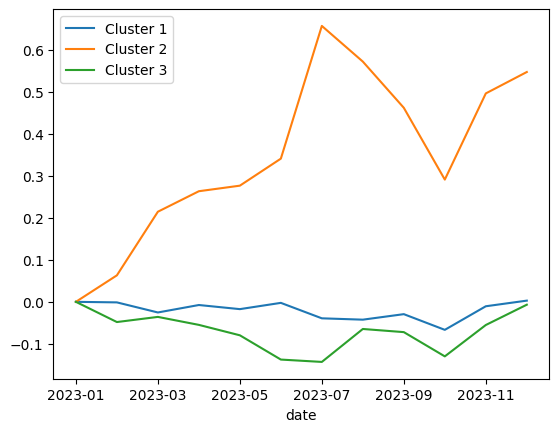

In [106]:
# 누적수익률

cluster_cumulative_returns = {}
for i, cluster_df in enumerate(clusters_list):
    # DataFrame에서 컬럼 이름 추출 (주식 코드 리스트)
    cluster = list(cluster_df.columns)
    
    # 유효한 주식 코드만 필터링
    valid_stocks = [stock for stock in cluster if stock in df_target.columns]
    if not valid_stocks:
        print(f"Cluster {i+1}에 유효한 종목이 없습니다.")
        continue
    
    # 유효한 주식에 대한 데이터 추출
    cluster_stocks = df_target[valid_stocks]
    # 동일 비중 수익률 계산 (평균 수익률)
    equal_weight_returns = cluster_stocks.mean(axis=1)
    
    # 시작 수익률을 0으로 설정하고 누적 수익률 계산
    cumulative_return = (1 + equal_weight_returns).cumprod()
    cumulative_return = cumulative_return / cumulative_return.iloc[0] - 1
    cluster_cumulative_returns[f'Cluster {i+1}'] = cumulative_return

# 클러스터별 누적 수익률 데이터프레임 생성
df_cluster_cumulative_returns = pd.DataFrame(cluster_cumulative_returns)

# 결과 출력
print(df_cluster_cumulative_returns)
df_cluster_cumulative_returns.plot()

In [117]:
# # 예측된 주식 수익률
# future_stock_returns = pd.DataFrame(
#     predicted_stock_returns,
#     index=pd.date_range('2024-01-01', '2024-04-30', freq='M'), 
#     columns=df_stock.columns
# )

# # 클러스터별 동일 비중 투자 수익률 계산
# cluster_returns = {}
# for i, cluster_df in enumerate(clusters_list):
#     # DataFrame에서 컬럼 이름 추출 (주식 코드 리스트)
#     cluster = list(cluster_df.columns)
    
#     # 유효한 주식 코드만 필터링
#     valid_stocks = [stock for stock in cluster if stock in future_stock_returns.columns]
#     if not valid_stocks:
#         print(f"Cluster {i+1}에 유효한 종목이 없습니다.")
#         continue
    
#     # 유효한 주식에 대한 데이터 추출
#     cluster_stocks = future_stock_returns[valid_stocks]
#     # 동일 비중 수익률 계산 (평균 수익률)
#     cluster_returns[f'Cluster {i+1}'] = cluster_stocks.mean(axis=1)

# # 클러스터별 수익률 데이터프레임 생성
# df_cluster_returns = pd.DataFrame(cluster_returns)

# # 결과 출력
# print(df_cluster_returns)

In [116]:
# # 각 시나리오별 클러스터별 동일 비중 수익률 계산
# scenario_cluster_returns = {}

# for scenario_name, scenario_data in scenarios.items():
#     print(f"\n[{scenario_name} Scenario] 클러스터별 수익률 계산 시작")
    
#     # 각 시나리오에 대해 예측용 데이터프레임 생성
#     predict_factor = pd.DataFrame(index=pd.date_range('2024-01-01', '2024-04-30', freq='M'), 
#                                   columns=df_factor.columns)
#     predict_factor.loc[:, :] = scenario_data.values.flatten()
    
#     # 주식 수익률 예측
#     predicted_stock_returns = rf_model.predict(predict_factor)
    
#     # 예측된 주식 수익률을 DataFrame으로 변환
#     future_stock_returns = pd.DataFrame(
#         predicted_stock_returns, 
#         index=predict_factor.index, 
#         columns=df_stock.columns
#     )
    
#     # 클러스터별 동일 비중 수익률 계산
#     cluster_returns = {}
#     for i, cluster_df in enumerate(clusters_list):
#         # DataFrame에서 컬럼 이름 추출 (주식 코드 리스트)
#         cluster = list(cluster_df.columns)
        
#         # 유효한 주식 코드만 필터링
#         valid_stocks = [stock for stock in cluster if stock in future_stock_returns.columns]
#         if not valid_stocks:
#             print(f"Cluster {i+1}에 유효한 종목이 없습니다.")
#             continue
        
#         # 유효한 주식에 대한 데이터 추출
#         cluster_stocks = future_stock_returns[valid_stocks]
#         # 동일 비중 수익률 계산 (평균 수익률)
#         cluster_returns[f'Cluster {i+1}'] = cluster_stocks.mean(axis=1)
    
#     # 클러스터별 수익률 데이터프레임 저장
#     scenario_cluster_returns[scenario_name] = pd.DataFrame(cluster_returns)

# # # 시나리오별 결과 확인
# # for scenario_name, returns_df in scenario_cluster_returns.items():
# #     print(f"\n[{scenario_name} Scenario] 클러스터별 동일 비중 수익률:")
# #     print(returns_df)

# # 최종 결과 출력
# for scenario_name, returns in scenario_cluster_returns.items():
#     print(f"\n[{scenario_name} Scenario] 클러스터별 수익률:")
#     for cluster, return_value in returns.items():
#         print(f"{cluster}: {return_value:.4f}")

In [115]:
# 각 시나리오별 클러스터별 동일 비중 수익률 계산
scenario_cluster_returns = {}

for scenario_name, scenario_data in scenarios.items():
    # print(f"\n[{scenario_name} Scenario] 클러스터별 수익률 계산 시작")
    
    # 각 시나리오에 대해 예측용 데이터프레임 생성
    predict_factor = pd.DataFrame(index=pd.date_range('2024-01-01', '2024-04-30', freq='M'), 
                                  columns=df_factor.columns)
    predict_factor.loc[:, :] = scenario_data.values.flatten()
    
    # 주식 수익률 예측
    predicted_stock_returns = rf_model.predict(predict_factor)
    
    # 예측된 주식 수익률을 DataFrame으로 변환
    future_stock_returns = pd.DataFrame(
        predicted_stock_returns, 
        index=predict_factor.index, 
        columns=df_stock.columns
    )
    
    # 클러스터별 동일 비중 수익률 계산
    cluster_returns = {}
    for i, cluster_df in enumerate(clusters_list):
        # DataFrame에서 컬럼 이름 추출 (주식 코드 리스트)
        cluster = list(cluster_df.columns)
        
        # 유효한 주식 코드만 필터링
        valid_stocks = [stock for stock in cluster if stock in future_stock_returns.columns]
        if not valid_stocks:
            print(f"Cluster {i+1}에 유효한 종목이 없습니다.")
            continue
        
        # 유효한 주식에 대한 데이터 추출
        cluster_stocks = future_stock_returns[valid_stocks]
        # 동일 비중 수익률 계산 (평균 수익률)
        cluster_returns[f'Cluster {i+1}'] = cluster_stocks.mean(axis=1).iloc[0]  # 첫 번째 값만 저장
    
    # 시나리오별 클러스터 수익률 저장
    scenario_cluster_returns[scenario_name] = cluster_returns

# 최종 결과 출력
for scenario_name, returns in scenario_cluster_returns.items():
    print(f"\n[{scenario_name} Scenario] 클러스터별 수익률:")
    for cluster, return_value in returns.items():
        print(f"{cluster}: {return_value:.4f}")



[Normal Scenario] 클러스터별 수익률:
Cluster 1: 0.0192
Cluster 2: 0.0306
Cluster 3: 0.0132

[Weak Scenario] 클러스터별 수익률:
Cluster 1: 0.0104
Cluster 2: 0.0187
Cluster 3: 0.0074

[Robust Scenario] 클러스터별 수익률:
Cluster 1: 0.0167
Cluster 2: 0.0222
Cluster 3: 0.0092


C:\Users\jh102\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\jh102\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\jh102\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)`

In [ ]:
# import statsmodels.api as sm

# def make_top_20_all_clusters_monthly(clusters_list: list) -> list:
#     top_20_stocks = {}

#     # 각 클러스터별로 K-ratio 계산 및 랭킹 매기기
#     for idx, df_cluster in enumerate(clusters_list):
#         # 종목 코드 리스트
#         ticker_list = df_cluster.columns

#         # 월별 수익률 계산 (pct_change는 월별 데이터 기준)
#         returns = df_cluster.pct_change().iloc[1:]
#         # 누적 로그 수익률 계산
#         cum_returns = np.log(1 + returns).cumsum()
#         # X축: 월별 인덱스
#         x = np.arange(len(returns))
#         K_ratio = {}

#         for ticker in ticker_list:
#             try:
#                 y = cum_returns[ticker].values
#                 # OLS 회귀 분석
#                 reg = sm.OLS(y, sm.add_constant(x)).fit()
#                 # K-ratio 계산
#                 result = float(reg.params[1] / reg.bse[1])
#             except:
#                 result = np.nan
#             K_ratio[ticker] = result

#         # K-ratio를 데이터프레임으로 변환
#         df_k_ratio = pd.DataFrame.from_dict(K_ratio, orient='index').reset_index()
#         df_k_ratio.columns = ['종목코드', 'K_ratio']

#         # K-ratio에 따라 종목을 랭킹
#         df_k_ratio['K_ratio_rank'] = df_k_ratio['K_ratio'].rank(axis=0, ascending=False)
#         # 상위 20개 종목 추출
#         top_20 = df_k_ratio[df_k_ratio['K_ratio_rank'] <= 20]
#         top_20_stocks[f'cluster_{idx}'] = top_20

#     # 상위 20개 종목을 합치고 중복 제거
#     top_20_all_clusters = []
#     for cluster_df in top_20_stocks.values():
#         top_20_all_clusters.extend(cluster_df['종목코드'].tolist())

#     return list(set(top_20_all_clusters))

In [ ]:
# # 각 클러스터에서 상위 20개 모멘텀 종목 추출
# top_20_all_clusters = make_top_20_all_clusters_monthly(clusters_list)

# # 새로운 포트폴리오로 필터링
# filtered_future_stock_returns = future_stock_returns[top_20_all_clusters]

# # 새로운 포트폴리오의 동일 비중 수익률 계산
# new_portfolio_returns = filtered_future_stock_returns.mean(axis=1).iloc[0]  # 첫 번째 값만 사용

# # 결과 출력
# print(f"새로운 포트폴리오 동일 비중 수익률: {new_portfolio_returns:.4f}")

새로운 포트폴리오 동일 비중 수익률: nan


C:\Users\jh102\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\jh102\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
C:\Users\jh102\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
C:\Users\jh102\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: divide by zero encounter